In [1]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
sys.path.append('../../../../')
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython
from dataset import Dataset

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-23 19:32:59.779692: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 19:32:59.789200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 19:32:59.800850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024

In [2]:
data = Dataset('15min')
data = data.preprocess()
# data = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv")
data.drop(columns=['Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
# scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
print(len(data.columns))
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
# numerical_data = scaler.fit_transform(data)

# Forming the sequences for both categorical and numerical data
n_future = 4  # Number of 15-min we want to look into the future based on the past (Out).
n_past = 10   # Number of past 15-min we want to use to predict the future (Step). Basically 4-hours
features = len(cols) - 1  # Number of features

def split_sequence(X, Y, steps, out):
    Xs, Ys = list(), list()
    for i in range(len(X)):
        end = i + steps
        outi = end + out
        if outi > len(X)-1:
            break
        seqx, seqy = X[i:end], Y[end:outi]
        Xs.append(seqx)
        Ys.append(seqy)
    return np.array(Xs), np.array(Ys)


categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)
data = pd.concat([data, categorical_data], axis = 1) #without categorical
X = data.drop(columns='Energy')
Y = data['Energy']
# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X.values, Y.values, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp


#scale only the training data, and then apply to the rest of the splits. Also two scalers, for X and Y
# n_samples, n_timesteps, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
# X_train = X_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# n_samples, n_timesteps, n_features = Y_train.shape
# Y_train_reshaped = Y_train.reshape(n_samples * n_timesteps, n_features)
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
# Y_train = Y_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)


#scale val/test sets
# X_val_reshaped = X_val.reshape(X_val.shape[0] * X_val.shape[1], X_val.shape[2])
X_val = scaler_X.transform(X_val)
# Y_val_reshaped = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1], Y_val.shape[2])
Y_val = scaler_Y.transform(Y_val.reshape(-1, 1))

# X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
X_test = scaler_X.transform(X_test)
# Y_test_reshaped = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2])
Y_test = scaler_Y.transform(Y_test.reshape(-1, 1))


X_train , Y_train =  split_sequence(X_train, Y_train, n_past, n_future)
X_val , Y_val =  split_sequence(X_val, Y_val, n_past, n_future)
X_test , Y_test =  split_sequence(X_test, Y_test, n_past, n_future)


print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecas

37
198.23530425829813
380.9409999996424
5.430999994277954
Train sizes:
(7411, 10, 330) (7411, 4, 1)
Validation sizes:
(641, 10, 330) (641, 4, 1)
Test sizes:
(642, 10, 330) (642, 4, 1)


In [14]:
Y_train[:, :, 0]

array([[0.55503449, 0.92112061, 0.66215547, 0.91138185],
       [0.92112061, 0.66215547, 0.91138185, 0.89422119],
       [0.66215547, 0.91138185, 0.89422119, 0.89503076],
       ...,
       [0.08722271, 0.05255785, 0.03812948, 0.04584166],
       [0.05255785, 0.03812948, 0.04584166, 0.06666667],
       [0.03812948, 0.04584166, 0.06666667, 0.10257516]])

In [3]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
from scikeras.wrappers import KerasRegressor
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython


class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        current_lr = float(keras.backend.get_value(lr))
        print(f"\nEpoch {epoch+1}: Learning rate is {current_lr}")

lr_schedule = ExponentialDecay(
    0.0001, decay_steps=2500, decay_rate=0.96, staircase=True
)

def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.2, input_shape=(X_train.shape[1], X_train.shape[2])), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=False, dropout= 0.1, recurrent_dropout= 0.2), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Dense(4))


    # model = Sequential([
    # Bidirectional(
    #     LSTM(units=50, 
    #          input_shape=(X_train.shape[1], X_train.shape[2]),  # (timesteps, features)
    #          return_sequences=True),   # Return output for each time step
    #     merge_mode='concat'),          # Merge the forward and backward LSTM outputs
    # Dropout(0.2),                      # Dropout with a rate of 20%
    
    # # Add another LSTM layer if needed
    # Bidirectional(
    #     LSTM(units=50, return_sequences=False),   # Second LSTM layer
    #     merge_mode='concat'),          # Merge the forward and backward outputs
    # Dropout(0.2),                      # Dropout with a rate of 20%

    # Dense(units=1)    # Apply Dense layer to each time step's output
    # ])
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae', 'mape'])

    return model

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './models/model-1h(15min).keras',        # Path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only the best model
    mode='min',             # Save when the quantity monitored has stopped decreasing
    verbose=1               # Verbosity mode
)

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=5,             # Number of epochs with no improvement after which training will stop
    mode='min',             # Stop when the quantity monitored has stopped decreasing
    verbose=1,              # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)
model = create_model()

history = model.fit(X_train, Y_train[:, :, 0], validation_data=(X_val, Y_val[:, :, 0]), epochs=20, batch_size=16, callbacks=[checkpoint_callback, early_stopping_callback, LearningRateLogger()], verbose=1, shuffle=False)

Epoch 1/20


I0000 00:00:1729701477.830584  120247 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729701477.861543  120247 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729701477.861704  120247 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729701477.862733  120247 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

 35/464 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2238 - mae: 0.3454 - mape: 168.0144

I0000 00:00:1729701482.425601  121532 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1646 - mae: 0.3300 - mape: 43228.9336
Epoch 1: val_loss improved from inf to 0.06607, saving model to ./models/model-1h(15min).keras

Epoch 1: Learning rate is 9.999999747378752e-05
464/464 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1645 - mae: 0.3299 - mape: 43267.1289 - val_loss: 0.0661 - val_mae: 0.2325 - val_mape: 144.1591
Epoch 2/20
463/464 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0927 - mae: 0.2621 - mape: 38344.0312
Epoch 2: val_loss improved from 0.06607 to 0.05733, saving model to ./models/model-1h(15min).keras

Epoch 2: Learning rate is 9.999999747378752e-05
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0927 - mae: 0.2620 - mape: 38411.4844 - val_loss: 0.0573 - val_mae: 0.2114 - val_mape: 119.3366
Epoch 3/20
461/464 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0805 - mae: 0.2423 - mape: 49635.7070
Epoch 3: val_loss improved from 0.05733 to 0.05340, saving model to ./models/model-1h(15min).keras

Epoch 3: Learning rate 

In [4]:
from keras.models import load_model
# load model

# model = load_model('./models/model-1-hour(15min).keras')
predictions = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step 


In [5]:
predictions.shape

(642, 4)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

zeros = np.zeros((X_test.shape[0], 37))
zeros[:, :4] = predictions
predictions = scaler_Y.inverse_transform(zeros)
predictions = predictions[:, :4]


zeros = np.zeros((X_test.shape[0], 37))
zeros[:, :4] = Y_test[:, :, 0]
original = scaler_Y.inverse_transform(zeros)
original = original[:, :4]

# Calculate metrics
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :return: MAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(original, predictions)
mse = mean_squared_error(original, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(original, predictions)
median_ae = median_absolute_error(original, predictions)
mape = mean_absolute_percentage_error(original, predictions)


n = len(original)
p = X_test.shape[1] 
adjusted_r2_value = adjusted_r2(r2, n, p)
# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")
print(f"Median Absolute Error: {median_ae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")

Mean Absolute Error (MAE): 67.3691982699945
Mean Squared Error (MSE): 7100.6510284850465
Root Mean Squared Error (RMSE): 84.26536078653581
R² Score: 0.5089465885270621
Adjusted R² Score: 0.5011644425449236
Median Absolute Error: 62.0620483258733
Mean Absolute Percentage Error (MAPE): 86.89002037813263 %


In [63]:
original[0], predictions[0]

(array([  18.17199999, 6377.45098231,   10.62598981,    8.97383559]),
 array([  28.90334343, 6920.74850392,   11.25213138,   19.55767064]))

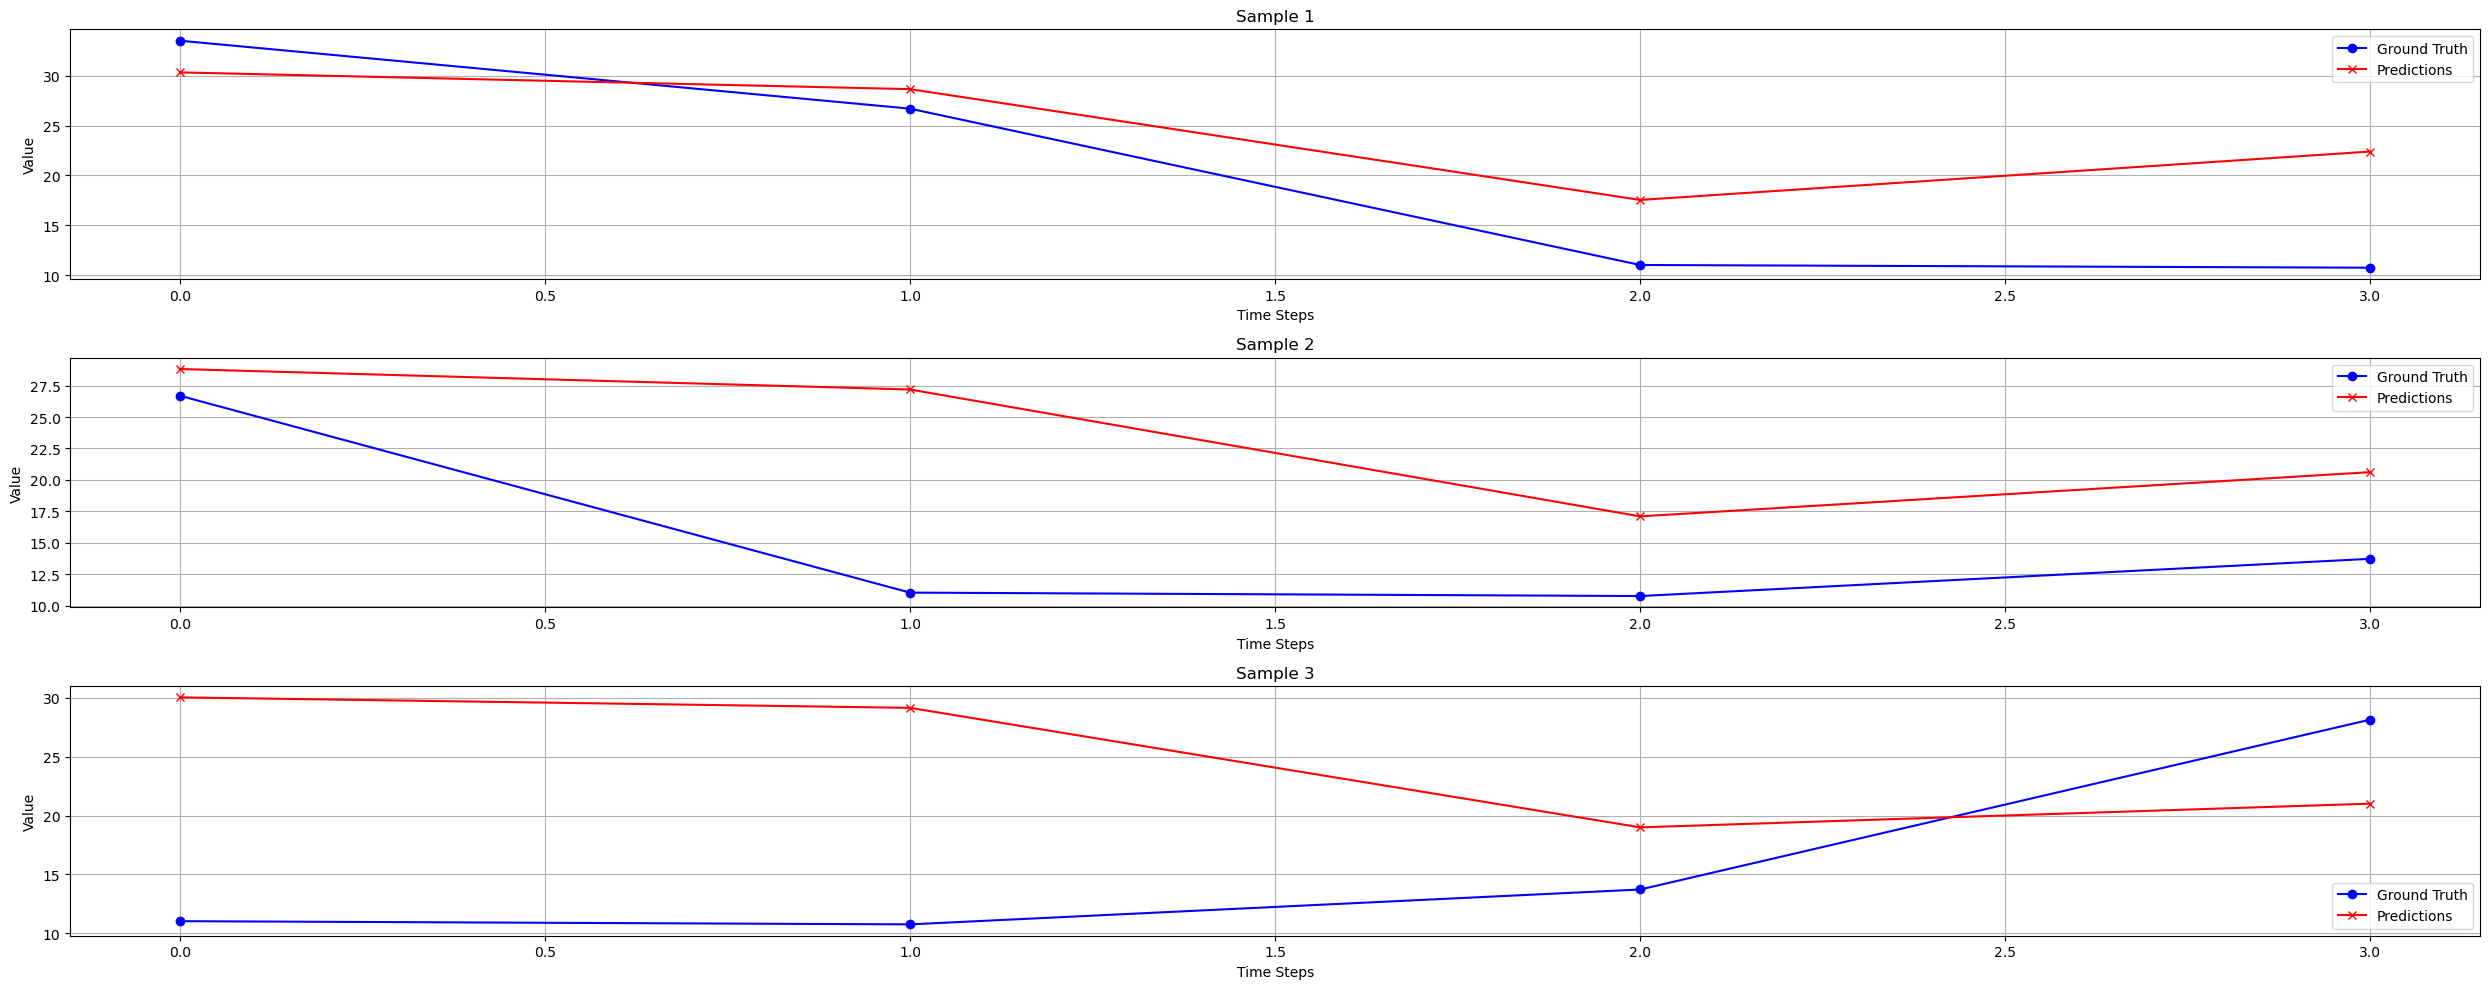

In [7]:
# Number of samples to visualize
n_samples_to_plot = 3  # Number of samples to plot

plt.figure(figsize=(25, 10))

for i in range(n_samples_to_plot):
    plt.subplot(n_samples_to_plot, 1, i + 1)
    plt.plot(range(4), original[i], marker='o', label='Ground Truth', color='blue')
    plt.plot(range(4), predictions[i], marker='x', label='Predictions', color='red')
    plt.title(f'Sample {i + 1}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
